### Multiround UNL Attack 

Jan 18 2024
TJ Kim

##### Summary
Load FAT model trained for 150 rounds and for 50 rounds try and inject FedAvg model into the system. Try different scaling rates and spread out the model replacement attack.

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [3]:
setting, num_user = "FedAvg_adv", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user)

# Load models for FAT and FedAvg
save_path_FAT = 'weights/cifar10/230922_baseline_train/FAT/'
save_path_FedAvg = 'weights/cifar10/230922_baseline_train/fedavg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


100%|██████████| 80/80 [00:00<00:00, 153.41it/s]


===> Initializing clients..


100%|██████████| 80/80 [00:36<00:00,  2.22it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


In [4]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [5]:
# Find mag norm 
mag_norm_FAT2FedAvg = []
for key in desired_keys: #params_FAT:

    diff =  params_FedAvg[key] - params_FAT[key]
    l2_norm = torch.norm(diff, p=2)

    mag_norm_FAT2FedAvg += [diff/torch.norm(diff,p=2)]


In [8]:
# Calculate uploaded model and download to attacker clients in aggregator
# Current version working under the assumption of close to convergence (no benign client pushback)
def calc_atk_model(model_inject, model_global, keys, weight_scale, weight_scale_2):

    atk_model = copy.deepcopy(model_global)
    inject_state_dict = model_inject.state_dict(keep_vars=True)
    global_state_dict = model_global.state_dict(keep_vars=True)
    return_state_dict = atk_model.state_dict(keep_vars=True)
    total_weight = weight_scale * weight_scale_2

    for key in keys:
        diff = inject_state_dict[key].data.clone() - global_state_dict[key].data.clone()
        return_state_dict[key].data = total_weight * diff + global_state_dict[key].data.clone()

    return atk_model

# Clone data from attack model to client model
def clone_model_weights(model_source, model_target, keys):
    target_state_dict = model_target.state_dict(keep_vars=True)
    source_state_dict = model_source.state_dict(keep_vars=True)
    
    for key in keys:
        target_state_dict[key].data = source_state_dict[key].data.clone()

    return

# Expand aggregator.mix() function
def UNL_mix(aggregator, adv_id, model_inject, keys, weight_scale_2, dump_flag=False):
    weight_scale = 1/aggregator.clients_weights
    model_global = aggregator.global_learners_ensemble[0].model

    # Give adversarial clients boosted models and train regular clients 1 round
    benign_id = list(range(len(aggregator.clients)))
    for a_id in adv_id:
        benign_id.remove(a_id)
        temp_atk_model = calc_atk_model(model_inject, model_global, keys, weight_scale[a_id], weight_scale_2)
        aggregator.clients[a_id].learners_ensemble[0].model = copy.deepcopy(temp_atk_model)

    for c_id in benign_id:
        aggregator.clients[c_id].step()

    # Aggregate model and download
    for learner_id, learner in enumerate(aggregator.global_learners_ensemble):
        learners = [client.learners_ensemble[learner_id] for client in aggregator.clients]
        if aggregator.aggregation_op is None:
            average_learners(learners, learner, weights=aggregator.clients_weights)
        elif aggregator.aggregation_op == 'median':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_median.pkl") 
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_median(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregator.aggregation_op == 'trimmed_mean':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_tm.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_tm(
                learners, 
                learner, 
                beta=0.05, 
                dump_path=dump_path
            )
        elif aggregator.aggregation_op == 'krum':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregator.aggregation_op == 'krum_modelwise':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum_modelwise.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum_modelwise(
                1,
                learners,
                learner,
                dump_path=dump_path
            )
        else:
            raise NotImplementedError


    # assign the updated model to all clients
    aggregator.update_clients()

    aggregator.c_round += 1

    # if aggregator.c_round % aggregator.log_freq == 0:
    #     aggregator.write_logs()
    return 

In [11]:
# Perform 50 rounds of FAT on FedAvg model 
num_rounds = 50
setting, num_user = "FedAvg_adv", 40
num_adv = 5
weight2 = 1/num_adv
adv_id = random.sample(range(num_user), num_adv)

test_acc_gather = []
adv_acc_gather = []
cosine_gather_layers = np.zeros([num_rounds, len(desired_keys)])

save_path_FedAvg_150R = 'weights/cifar10/231031_FAT150round/FAT'

aggregator, clients, args_ = set_args(setting, num_user)

# Test performance of aggregator on data 
aggregator.load_state(dir_path = save_path_FedAvg_150R)
aggregator.update_clients()
model_FA = pull_model_from_agg(aggregator)
model_FA.eval()
acc, adv_acc = get_adv_acc(aggregator, model_FA)

prev_model = copy.deepcopy(model_FA)

print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
test_acc_gather+= [np.mean(acc)]
adv_acc_gather += [np.mean(adv_acc)]


# Setting evasion attack parameters
x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
atk_params = PGD_Params()
atk_params.set_params(batch_size=1, iteration = 10,
                target = -1, x_val_min = x_min, x_val_max = x_max,
                step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)

adv_update_rnd_freq = 10

for i in range(num_rounds):

    # Per round Freq
    if i%adv_update_rnd_freq == 0:
        print("updating adv data set")
        # add adv dataset update
        G = 0.5
        Fu = np.ones(num_user) * G

        # Assign proportion and attack params
        for c in range(len(clients)):
            aggregator.clients[c].set_adv_params(Fu[i], atk_params)
            aggregator.clients[c].update_advnn()
            aggregator.clients[c].assign_advdataset()

    # aggregator.mix()
    UNL_mix(aggregator, adv_id, model_inject = model_Fedavg, keys = desired_keys, weight_scale_2 = weight2, dump_flag=False)
    model_overfit = pull_model_from_agg(aggregator)
    model_overfit.eval()
    acc, adv_acc = get_adv_acc(aggregator, model_overfit)

    diffnn = get_diff_NN(prev_model, model_overfit, desired_keys)

    cosine_gather_layers[i,:] = diff_cosine_similarity(diffnn, mag_norm_FAT2FedAvg, len(desired_keys))
    print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
    prev_model = copy.deepcopy(model_overfit)
    # Perform gradient direction gathering

==> Clients initialization..
===> Building data iterators..


100%|██████████| 80/80 [00:00<00:00, 135.09it/s]


===> Initializing clients..


100%|██████████| 80/80 [00:30<00:00,  2.62it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


Test acc:  0.8125 adv acc:  0.4000000059604645
updating adv data set
round 0 Test acc:  0.3125 adv acc:  0.0
round 1 Test acc:  0.6500000357627869 adv acc:  0.012500000186264515
round 2 Test acc:  0.800000011920929 adv acc:  0.012500000186264515
round 3 Test acc:  0.8375000357627869 adv acc:  0.0
round 4 Test acc:  0.8125 adv acc:  0.0
round 5 Test acc:  0.8500000238418579 adv acc:  0.0


KeyboardInterrupt: 

In [ ]:
diff_cosine_similarity(diffnn, mag_norm_FAT2FedAvg, len(desired_keys)).shape

(158,)

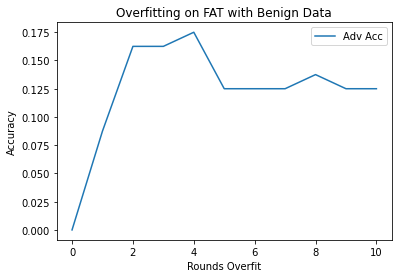

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = range(len(test_acc_gather))  # 100 points from 0 to 10
y1 = test_acc_gather               # Sine function for the first line
y2 = adv_acc_gather             # Cosine function for the second line

# Plotting the lines
# plt.plot(x, y1, label='Test Acc')
plt.plot(x, y2, label='Adv Acc')

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Accuracy')
plt.title('Overfitting on FAT with Benign Data')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


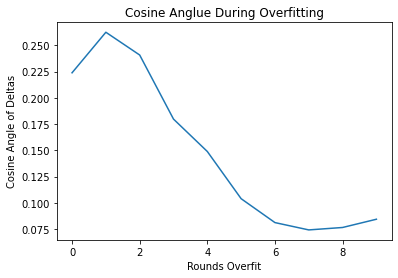

In [ ]:
np.mean(cosine_gather_layers,axis = 1)

import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
y1 = np.mean(cosine_gather_layers,axis = 1)
x = range(len(y1))  # 100 points from 0 to 10


# Plotting the lines
plt.plot(x, y1, label='Cosine Angle')

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Cosine Angle of Deltas')
plt.title('Cosine Anglue During Overfitting')

# Adding a legend
# plt.legend()

# Display the plot
plt.show()


In [ ]:
cosine_gather_layers[:,10]

array([0.67, 0.65, 0.61, 0.54, 0.59, 0.51, 0.35, 0.32, 0.26, 0.30])

In [ ]:
# Get number of params per desired key
size = np.zeros(len(desired_keys))
i = 0
for key in desired_keys:
    size[i]=params_FAT[key].flatten().shape[0]
    i += 1

prop = size/np.sum(size)

cosine_propped = np.zeros(cosine_gather_layers.shape)

# for t in range(num_rounds):
#     cosine_propped[t,:] = np.average(cosine_gather_layers[t,:], weights = prop)

np.average(cosine_gather_layers, weights = prop, axis = 1)

array([0.14, 0.15, 0.10, 0.06, 0.04, 0.02, 0.02, 0.02, 0.02, 0.02])

In [ ]:
np.average(cosine_gather_layers[5], weights = prop)

0.024007904378071064

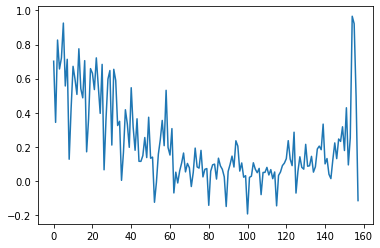

In [ ]:
plt.plot(cosine_gather_layers[0])